---
title: "MRI Super-Resolution with Diffusion Models"
date: 06-20-2025 
author: Nathan Bresette 
categories: [Medical Imaging, Deep Learning, PyTorch, Diffusion Models]
image: "mriddpm.png"

output:
  html_document:
    df_print: paged
editor_options:
  chunk_output_type: inline
format:
  html:
    code-link: true
    code-fold: true
    code-overflow: wrap
    warning: false
---

MRI super-resolution using diffusion models on limited hardware with data augmentation and evaluation metrics.

# Introduction

## Purpose of Project
Magnetic Resonance Imaging (MRI) is vital for neuroscience and medical diagnostics. However, high-resolution MR images is time-consuming and expensive. It is also constrained by hardware limitations and patient comfort. Super-resolution techniques offer a powerful solution by reconstructing high-quality images from lower-resolution inputs which enhances clinical utility without increasing scan time. In this project, I explore the application of *diffusion-based deep learning models* to MRI super-resolution, leveraging the OASIS dataset.

## Methods
The primary model used in this project is a *UNet-based Denoising Diffusion Probabilistic Model (DDPM)*, implemented using HuggingFace's diffusers library. The model learns to iteratively remove noise from high-resolution images while being conditioned on upsampled low-resolution inputs. Compared to GANs, diffusion models offer improved training stability and produce more diverse, less artifact-prone outputs—key benefits in medical imaging tasks where realism and detail are critical. See 'Nathan's Notes' for my detailed notes on the differences.

## Computing Limitations
One of the core challenges of this project was working on a Mac machine with limited computational power. This constraint required significant adaptations to standard approaches—such as reducing image dimensions, limiting batch sizes, and restricting the number of training epochs. I extracted and saved individual 2D grayscale slices from 3D MRI volumes, a practical compromise that preserved key anatomical information while reducing memory load. To further address data scarcity and prevent overfitting, I applied a variety of augmentation techniques, including rotation, flipping, affine transforms, and brightness/contrast jittering. This helped increase my tiny dataset of 8 images significantly

I would explore larger batch sizes, deeper UNets, and longer diffusion chains for improved image fidelity. In particular, models like SR3 (Super-Resolution via Repeated Refinement) or latent diffusion models (LDMs) trained with multi-resolution or multi-slice 3D context could significantly enhance output quality. Additionally, integrating perceptual loss functions (e.g., VGG-based) and domain-specific priors (like anatomical landmarks) could offer further gains in realism and utility.

## Takeaways
Despite the poor performance of the model—evidenced by noisy, blurry outputs and low evaluation scores (PSNR ≈ 8.09 dB, SSIM ≈ 0.165), this project was an invaluable learning experience. I successfully implemented a complete diffusion-based super-resolution pipeline from scratch, including dataset preparation, augmentation, model training, and inference, all within the limitations of a Mac. If I had access to more computing power, I would experiment with longer training schedules, more complex U-Net backbones, and potentially newer models like DDIM or StableSR to achieve higher-quality reconstructions.

# 0. Set Data Paths

In [1]:
import os

base_dir = os.path.expanduser("~/oasis_project/data")

png_dir   = os.path.join(base_dir, "PNG_SLICES")
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")

model_path = os.path.expanduser("~/oasis_project/unet_sr_model.pth")

# 1. Data Conversion
- Extracting 2D slices from 3D MRI volumes greatly reduces memory usage and computation time, enabling training on modest hardware.  
- Saving images as grayscale PNG simplifies data handling and visualization, matching the single-channel nature of MRI.  
- This approach balances preserving anatomical info with practical resource constraints.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from nibabel import load
from shutil import copyfile

def convert_oasis_to_png():
    input_dir = os.path.expanduser("~/oasis_project/data/disc1")
    output_dir = os.path.expanduser("~/oasis_project/data/PNG_SLICES")
    os.makedirs(output_dir, exist_ok=True)

    for subject_folder in os.listdir(input_dir):
        if subject_folder.startswith('OAS1_'):
            img_path = os.path.join(input_dir, subject_folder, 
                                  "PROCESSED", "MPRAGE", "SUBJ_111",
                                  f"{subject_folder}_mpr_n3_anon_sbj_111.img")
            
            if os.path.exists(img_path):
                try:
                    img = np.squeeze(load(img_path).get_fdata())
                    if img.ndim == 3:
                        slice_idx = img.shape[2] // 2
                        plt.imsave(f"{output_dir}/{subject_folder}.png", 
                                 img[:, :, slice_idx], 
                                 cmap="gray")
                        print(f"Converted {subject_folder}")
                except Exception as e:
                    print(f"Failed on {subject_folder}: {str(e)}")

if __name__ == "__main__":
    convert_oasis_to_png()

Converted OAS1_0016_MR1
Converted OAS1_0015_MR1


Converted OAS1_0038_MR1
Converted OAS1_0039_MR1


Converted OAS1_0007_MR1
Converted OAS1_0020_MR1


Converted OAS1_0034_MR1
Converted OAS1_0026_MR1


# 2. Example Image
- A sample image looks good and ready!

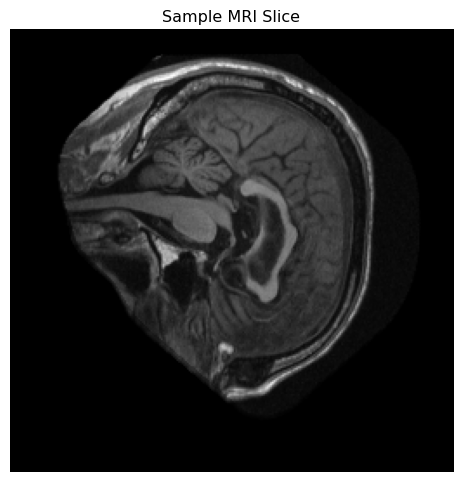

In [3]:
img_path = os.path.expanduser("~/oasis_project/data/PNG_SLICES/OAS1_0016_MR1.png")
img = plt.imread(img_path)
plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("Sample MRI Slice")
plt.show()

# 3. Dataset Splitting
- An 80/20 split balances maximizing training data with enough validation data to detect overfitting or underfitting.
- Random shuffling avoids any ordering bias by subject or acquisition date.
- Copying files creates clear and isolated train/val folders, simplifying downstream data loading.
- Due to low computing power, I only have 6 training images and 2 validation images.

In [4]:
import random
from shutil import copyfile, rmtree

png_dir = os.path.expanduser("~/oasis_project/data/PNG_SLICES")
train_dir = os.path.expanduser("~/oasis_project/data/train")
val_dir = os.path.expanduser("~/oasis_project/data/val")
def split_dataset():
    # Clear train and val directories before splitting
    if os.path.exists(train_dir):
        rmtree(train_dir)
    if os.path.exists(val_dir):
        rmtree(val_dir)
    
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    all_images = [f for f in os.listdir(png_dir) if f.endswith('.png')]
    random.shuffle(all_images)
    
    split_idx = int(0.8 * len(all_images))
    print(f"Total images: {len(all_images)}, Train: {split_idx}, Validation: {len(all_images) - split_idx}")

    for i, img in enumerate(all_images):
        dest = train_dir if i < split_idx else val_dir
        copyfile(os.path.join(png_dir, img), os.path.join(dest, img))
    
    print(f"Training images after split: {len(os.listdir(train_dir))}")
    print(f"Validation images after split: {len(os.listdir(val_dir))}")

if __name__ == "__main__":
    split_dataset()

Total images: 8, Train: 6, Validation: 2
Training images after split: 6
Validation images after split: 2


# 4. Dataset Class
- Normalizing images to [-1, 1] stabilizes and speeds up neural network training by centering and scaling inputs.

- Bicubic downsampling simulates realistic low-resolution images for super-resolution training.

- Using PyTorch Dataset allows efficient data loading with lazy evaluation and easy batching.

In [5]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import torch.nn.functional as F

class MRIDataset(Dataset):
    def __init__(self, root_dir, hr_size=256, lr_size=128, augment=True):
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.png')]
        self.hr_size = hr_size
        self.lr_size = lr_size
        self.augment = augment

        # Data augmentations
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomRotation(degrees=10),
            transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.9, 1.1), shear = 5),  
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])  # maps [0,1] → [-1,1]
        ])

        self.default_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('L').resize((self.hr_size, self.hr_size))
        
        if self.augment:
            hr_img = self.transform(img)
        else:
            hr_img = self.default_transform(img)

        # Simulate LR version via bicubic downsampling and upsampling
        lr_img = F.interpolate(hr_img.unsqueeze(0), size=self.lr_size, mode='bicubic')
        lr_img = F.interpolate(lr_img, size=self.hr_size, mode='bicubic').squeeze(0)

        return lr_img, hr_img

# 5. Diffusion Model Training
- UNet balances preserving local details and capturing global context, essential for image super-resolution.

- Diffusion models are more stable than GANs, avoiding mode collapse and producing diverse outputs.

- 10 epochs and batch size 2 reduce training time and GPU memory needs, suitable for limited hardware.

- Adam optimizer with learning rate 1e-4 is a good default for convergence speed and stability.

- Concatenating upsampled LR and noisy HR images conditions the model for super-resolution.

- Saving model weights lets me reuse without retraining, saving time and compute.

In [6]:
import torch
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel

def train_diffusion():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = UNet2DModel(
        sample_size=256,
        in_channels=2,
        out_channels=1,
        layers_per_block=2,
        block_out_channels=(64, 128, 256, 512),
        down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
        up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D")
    ).to(device)
    
    # Adding and removing noise during training
    noise_scheduler = DDPMScheduler(num_train_timesteps=500, beta_schedule="linear")
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    train_dataset = MRIDataset(
        os.path.expanduser("~/oasis_project/data/train"),
        hr_size=256,
        lr_size=128,
        augment = True
    )
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    
    for epoch in range(10):
        for batch_idx, (lr_images, hr_images) in enumerate(train_loader):
            lr_images = lr_images.to(device)
            hr_images = hr_images.to(device)
            
            noise = torch.randn_like(hr_images)
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, 
                (hr_images.shape[0],)
            ).long().to(device)
            
            noisy_images = noise_scheduler.add_noise(hr_images, noise, timesteps)
            
            lr_upsampled = F.interpolate(lr_images, size=hr_images.shape[-2:], mode='bilinear', align_corners=False)
            
            noise_pred = model(
                torch.cat([lr_upsampled, noisy_images], dim=1), timesteps
            ).sample
            
            loss = F.l1_loss(noise_pred, noise)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}")

    save_path = os.path.expanduser("~/oasis_project/unet_sr_model.pth")
    torch.save(model.state_dict(), save_path)
    # print(f"Model saved to: {save_path}")

if __name__ == "__main__":
    train_diffusion()

Epoch 0, Batch 0, Loss: 0.8596


Epoch 1, Batch 0, Loss: 0.6247


Epoch 2, Batch 0, Loss: 0.3125


Epoch 3, Batch 0, Loss: 0.2303


Epoch 4, Batch 0, Loss: 0.2043


Epoch 5, Batch 0, Loss: 0.4182


Epoch 6, Batch 0, Loss: 0.1558


Epoch 7, Batch 0, Loss: 0.1323


Epoch 8, Batch 0, Loss: 0.4481


Epoch 9, Batch 0, Loss: 0.3253


# 6. Super Resolution Inference

In [7]:
from tqdm import tqdm 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet2DModel(
    sample_size=256,
    in_channels=2,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D")
).to(device)

model.load_state_dict(torch.load(os.path.expanduser("~/oasis_project/unet_sr_model.pth"), map_location=device))
model.eval()

noise_scheduler = DDPMScheduler(num_train_timesteps=500, beta_schedule="linear")
noise_scheduler.set_timesteps(num_inference_steps=50)  # Speed up inference

@torch.no_grad()
def super_resolve(model, lr_image):
    model.eval()
    lr_image = lr_image.unsqueeze(0).to(device)  # [1, 1, 128, 128]
    
    lr_image = F.interpolate(lr_image, size=(256, 256), mode='bilinear', align_corners=False)
    
    noisy_output = torch.randn((1, 1, 256, 256), device=device)
    
    for t in tqdm(noise_scheduler.timesteps, desc="Diffusion steps"):
        t_tensor = torch.tensor([t], device=device)
        noisy_output = noise_scheduler.step(
            model(torch.cat([lr_image, noisy_output], dim=1), t_tensor).sample,
            t,
            noisy_output
        ).prev_sample
    
    return (noisy_output.squeeze().cpu().numpy() + 1) * 127.5

Diffusion steps:   0%|          | 0/50 [00:00<?, ?it/s]

Diffusion steps:   2%|▏         | 1/50 [00:04<03:20,  4.10s/it]

Diffusion steps:   4%|▍         | 2/50 [00:08<03:13,  4.04s/it]

Diffusion steps:   6%|▌         | 3/50 [00:12<03:08,  4.01s/it]

Diffusion steps:   8%|▊         | 4/50 [00:16<03:06,  4.05s/it]

Diffusion steps:  10%|█         | 5/50 [00:20<03:01,  4.02s/it]

Diffusion steps:  12%|█▏        | 6/50 [00:24<02:57,  4.03s/it]

Diffusion steps:  14%|█▍        | 7/50 [00:28<02:54,  4.06s/it]

Diffusion steps:  16%|█▌        | 8/50 [00:32<02:49,  4.03s/it]

Diffusion steps:  18%|█▊        | 9/50 [00:36<02:44,  4.02s/it]

Diffusion steps:  20%|██        | 10/50 [00:40<02:41,  4.04s/it]

Diffusion steps:  22%|██▏       | 11/50 [00:44<02:36,  4.03s/it]

Diffusion steps:  24%|██▍       | 12/50 [00:48<02:35,  4.08s/it]

Diffusion steps:  26%|██▌       | 13/50 [00:52<02:30,  4.06s/it]

Diffusion steps:  28%|██▊       | 14/50 [00:56<02:25,  4.04s/it]

Diffusion steps:  30%|███       | 15/50 [01:00<02:22,  4.07s/it]

Diffusion steps:  32%|███▏      | 16/50 [01:04<02:17,  4.06s/it]

Diffusion steps:  34%|███▍      | 17/50 [01:08<02:13,  4.05s/it]

Diffusion steps:  36%|███▌      | 18/50 [01:12<02:09,  4.06s/it]

Diffusion steps:  38%|███▊      | 19/50 [01:16<02:05,  4.04s/it]

Diffusion steps:  40%|████      | 20/50 [01:21<02:02,  4.07s/it]

Diffusion steps:  42%|████▏     | 21/50 [01:25<01:57,  4.06s/it]

Diffusion steps:  44%|████▍     | 22/50 [01:29<01:53,  4.05s/it]

Diffusion steps:  46%|████▌     | 23/50 [01:33<01:49,  4.07s/it]

Diffusion steps:  48%|████▊     | 24/50 [01:37<01:45,  4.05s/it]

Diffusion steps:  50%|█████     | 25/50 [01:41<01:41,  4.05s/it]

Diffusion steps:  52%|█████▏    | 26/50 [01:45<01:37,  4.07s/it]

Diffusion steps:  54%|█████▍    | 27/50 [01:49<01:33,  4.06s/it]

Diffusion steps:  56%|█████▌    | 28/50 [01:53<01:30,  4.11s/it]

Diffusion steps:  58%|█████▊    | 29/50 [01:57<01:25,  4.09s/it]

Diffusion steps:  60%|██████    | 30/50 [02:01<01:21,  4.07s/it]

Diffusion steps:  62%|██████▏   | 31/50 [02:05<01:17,  4.10s/it]

Diffusion steps:  64%|██████▍   | 32/50 [02:10<01:14,  4.15s/it]

Diffusion steps:  66%|██████▌   | 33/50 [02:14<01:10,  4.13s/it]

Diffusion steps:  68%|██████▊   | 34/50 [02:18<01:05,  4.10s/it]

Diffusion steps:  70%|███████   | 35/50 [02:22<01:01,  4.09s/it]

Diffusion steps:  72%|███████▏  | 36/50 [02:26<00:57,  4.11s/it]

Diffusion steps:  74%|███████▍  | 37/50 [02:30<00:53,  4.09s/it]

Diffusion steps:  76%|███████▌  | 38/50 [02:34<00:48,  4.07s/it]

Diffusion steps:  78%|███████▊  | 39/50 [02:38<00:44,  4.09s/it]

Diffusion steps:  80%|████████  | 40/50 [02:42<00:40,  4.06s/it]

Diffusion steps:  82%|████████▏ | 41/50 [02:46<00:36,  4.05s/it]

Diffusion steps:  84%|████████▍ | 42/50 [02:50<00:32,  4.06s/it]

Diffusion steps:  86%|████████▌ | 43/50 [02:54<00:28,  4.05s/it]

Diffusion steps:  88%|████████▊ | 44/50 [02:59<00:24,  4.10s/it]

Diffusion steps:  90%|█████████ | 45/50 [03:03<00:20,  4.08s/it]

Diffusion steps:  92%|█████████▏| 46/50 [03:07<00:16,  4.06s/it]

Diffusion steps:  94%|█████████▍| 47/50 [03:11<00:12,  4.07s/it]

Diffusion steps:  96%|█████████▌| 48/50 [03:15<00:08,  4.05s/it]

Diffusion steps:  98%|█████████▊| 49/50 [03:19<00:04,  4.07s/it]

Diffusion steps: 100%|██████████| 50/50 [03:23<00:00,  4.05s/it]

Diffusion steps: 100%|██████████| 50/50 [03:23<00:00,  4.07s/it]

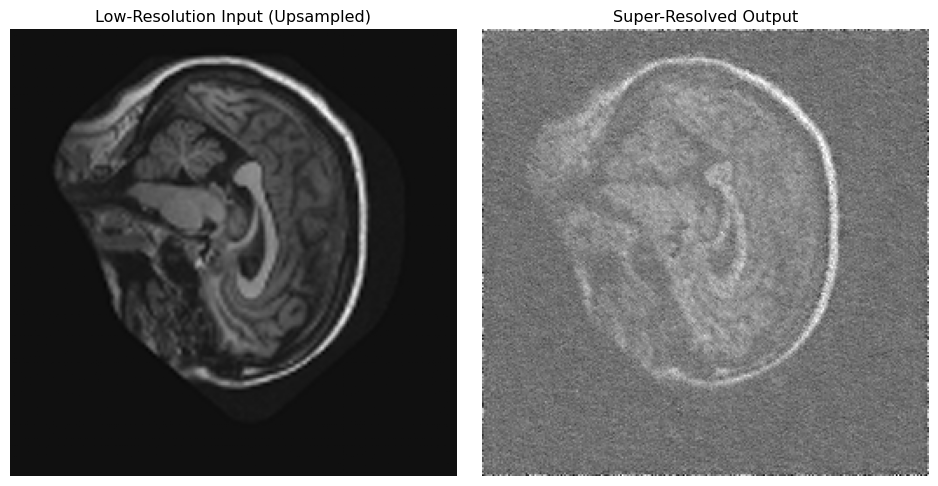

In [8]:
val_dataset = MRIDataset(val_dir, hr_size=256, lr_size=128, augment=False)

test_img_lr, test_img_hr = val_dataset[0]  # first image in val set

test_img = test_img_lr  # This is the low-res input tensor

sr_img = super_resolve(model, test_img)

lr_img_upsampled = F.interpolate(test_img.unsqueeze(0), size=(256, 256), mode='bilinear').squeeze().numpy()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(lr_img_upsampled, cmap='gray')
plt.title("Low-Resolution Input (Upsampled)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.clip(sr_img, 0, 255), cmap='gray')
plt.title("Super-Resolved Output")
plt.axis('off')

plt.tight_layout()
plt.show()

# 7. Evaluation

In [9]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def evaluate(model, val_dir):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = model.to(device)
    model.eval()

    noise_scheduler = DDPMScheduler(num_train_timesteps=500, beta_schedule="linear")
    noise_scheduler.set_timesteps(num_inference_steps=50)

    val_dataset = MRIDataset(val_dir, hr_size=256, lr_size=128)
    val_loader = DataLoader(val_dataset, batch_size=1)

    psnrs, ssims = [], []

    for lr, hr in val_loader:
        lr = lr.squeeze(0)  
        hr = hr.squeeze().cpu().numpy()
        hr = (hr + 1) * 127.5  

        sr = super_resolve(model, lr)
        
        psnrs.append(psnr(hr, sr, data_range=255))
        ssims.append(ssim(hr, sr, data_range=255))

    print(f"Mean PSNR: {np.mean(psnrs):.2f} dB")
    print(f"Mean SSIM: {np.mean(ssims):.4f}")

evaluate(model, val_dir)

Diffusion steps:   0%|          | 0/50 [00:00<?, ?it/s]

Diffusion steps:   2%|▏         | 1/50 [00:04<03:16,  4.00s/it]

Diffusion steps:   4%|▍         | 2/50 [00:08<03:15,  4.06s/it]

Diffusion steps:   6%|▌         | 3/50 [00:12<03:09,  4.03s/it]

Diffusion steps:   8%|▊         | 4/50 [00:16<03:04,  4.02s/it]

Diffusion steps:  10%|█         | 5/50 [00:20<03:01,  4.04s/it]

Diffusion steps:  12%|█▏        | 6/50 [00:24<02:56,  4.02s/it]

Diffusion steps:  14%|█▍        | 7/50 [00:28<02:53,  4.03s/it]

Diffusion steps:  16%|█▌        | 8/50 [00:32<02:48,  4.02s/it]

Diffusion steps:  18%|█▊        | 9/50 [00:36<02:43,  4.00s/it]

Diffusion steps:  20%|██        | 10/50 [00:40<02:41,  4.03s/it]

Diffusion steps:  22%|██▏       | 11/50 [00:44<02:36,  4.02s/it]

Diffusion steps:  24%|██▍       | 12/50 [00:48<02:32,  4.01s/it]

Diffusion steps:  26%|██▌       | 13/50 [00:52<02:29,  4.05s/it]

Diffusion steps:  28%|██▊       | 14/50 [00:56<02:25,  4.05s/it]

Diffusion steps:  30%|███       | 15/50 [01:00<02:21,  4.05s/it]

Diffusion steps:  32%|███▏      | 16/50 [01:04<02:17,  4.04s/it]

Diffusion steps:  34%|███▍      | 17/50 [01:08<02:12,  4.02s/it]

Diffusion steps:  36%|███▌      | 18/50 [01:12<02:09,  4.06s/it]

Diffusion steps:  38%|███▊      | 19/50 [01:16<02:05,  4.04s/it]

Diffusion steps:  40%|████      | 20/50 [01:20<02:00,  4.02s/it]

Diffusion steps:  42%|████▏     | 21/50 [01:24<01:57,  4.04s/it]

Diffusion steps:  44%|████▍     | 22/50 [01:28<01:52,  4.02s/it]

Diffusion steps:  46%|████▌     | 23/50 [01:32<01:48,  4.01s/it]

Diffusion steps:  48%|████▊     | 24/50 [01:36<01:44,  4.01s/it]

Diffusion steps:  50%|█████     | 25/50 [01:40<01:40,  4.02s/it]

Diffusion steps:  52%|█████▏    | 26/50 [01:44<01:37,  4.07s/it]

Diffusion steps:  54%|█████▍    | 27/50 [01:48<01:33,  4.05s/it]

Diffusion steps:  56%|█████▌    | 28/50 [01:52<01:28,  4.03s/it]

Diffusion steps:  58%|█████▊    | 29/50 [01:56<01:25,  4.05s/it]

Diffusion steps:  60%|██████    | 30/50 [02:00<01:20,  4.03s/it]

Diffusion steps:  62%|██████▏   | 31/50 [02:04<01:16,  4.03s/it]

Diffusion steps:  64%|██████▍   | 32/50 [02:09<01:12,  4.04s/it]

Diffusion steps:  66%|██████▌   | 33/50 [02:13<01:08,  4.04s/it]

Diffusion steps:  68%|██████▊   | 34/50 [02:17<01:05,  4.09s/it]

Diffusion steps:  70%|███████   | 35/50 [02:21<01:01,  4.07s/it]

Diffusion steps:  72%|███████▏  | 36/50 [02:25<00:56,  4.05s/it]

Diffusion steps:  74%|███████▍  | 37/50 [02:29<00:53,  4.08s/it]

Diffusion steps:  76%|███████▌  | 38/50 [02:33<00:48,  4.05s/it]

Diffusion steps:  78%|███████▊  | 39/50 [02:37<00:44,  4.05s/it]

Diffusion steps:  80%|████████  | 40/50 [02:41<00:40,  4.06s/it]

Diffusion steps:  82%|████████▏ | 41/50 [02:45<00:36,  4.04s/it]

Diffusion steps:  84%|████████▍ | 42/50 [02:49<00:32,  4.08s/it]

Diffusion steps:  86%|████████▌ | 43/50 [02:53<00:28,  4.06s/it]

Diffusion steps:  88%|████████▊ | 44/50 [02:57<00:24,  4.05s/it]

Diffusion steps:  90%|█████████ | 45/50 [03:01<00:20,  4.07s/it]

Diffusion steps:  92%|█████████▏| 46/50 [03:05<00:16,  4.06s/it]

Diffusion steps:  94%|█████████▍| 47/50 [03:10<00:12,  4.09s/it]

Diffusion steps:  96%|█████████▌| 48/50 [03:14<00:08,  4.08s/it]

Diffusion steps:  98%|█████████▊| 49/50 [03:18<00:04,  4.06s/it]

Diffusion steps: 100%|██████████| 50/50 [03:22<00:00,  4.10s/it]

Diffusion steps: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it]

Diffusion steps:   0%|          | 0/50 [00:00<?, ?it/s]

Diffusion steps:   2%|▏         | 1/50 [00:04<03:20,  4.08s/it]

Diffusion steps:   4%|▍         | 2/50 [00:08<03:15,  4.07s/it]

Diffusion steps:   6%|▌         | 3/50 [00:12<03:15,  4.15s/it]

Diffusion steps:   8%|▊         | 4/50 [00:16<03:09,  4.11s/it]

Diffusion steps:  10%|█         | 5/50 [00:20<03:07,  4.17s/it]

Diffusion steps:  12%|█▏        | 6/50 [00:24<03:03,  4.16s/it]

Diffusion steps:  14%|█▍        | 7/50 [00:28<02:58,  4.14s/it]

Diffusion steps:  16%|█▌        | 8/50 [00:33<02:54,  4.16s/it]

Diffusion steps:  18%|█▊        | 9/50 [00:37<02:49,  4.12s/it]

Diffusion steps:  20%|██        | 10/50 [00:41<02:43,  4.10s/it]

Diffusion steps:  22%|██▏       | 11/50 [00:45<02:41,  4.14s/it]

Diffusion steps:  24%|██▍       | 12/50 [00:49<02:36,  4.12s/it]

Diffusion steps:  26%|██▌       | 13/50 [00:53<02:33,  4.14s/it]

Diffusion steps:  28%|██▊       | 14/50 [00:57<02:28,  4.12s/it]

Diffusion steps:  30%|███       | 15/50 [01:01<02:23,  4.09s/it]

Diffusion steps:  32%|███▏      | 16/50 [01:05<02:19,  4.11s/it]

Diffusion steps:  34%|███▍      | 17/50 [01:10<02:14,  4.08s/it]

Diffusion steps:  36%|███▌      | 18/50 [01:14<02:09,  4.06s/it]

Diffusion steps:  38%|███▊      | 19/50 [01:18<02:06,  4.09s/it]

Diffusion steps:  40%|████      | 20/50 [01:22<02:02,  4.07s/it]

Diffusion steps:  42%|████▏     | 21/50 [01:26<01:58,  4.10s/it]

Diffusion steps:  44%|████▍     | 22/50 [01:30<01:54,  4.08s/it]

Diffusion steps:  46%|████▌     | 23/50 [01:34<01:49,  4.07s/it]

Diffusion steps:  48%|████▊     | 24/50 [01:38<01:46,  4.11s/it]

Diffusion steps:  50%|█████     | 25/50 [01:42<01:42,  4.09s/it]

Diffusion steps:  52%|█████▏    | 26/50 [01:46<01:37,  4.07s/it]

Diffusion steps:  54%|█████▍    | 27/50 [01:50<01:34,  4.09s/it]

Diffusion steps:  56%|█████▌    | 28/50 [01:54<01:29,  4.07s/it]

Diffusion steps:  58%|█████▊    | 29/50 [01:59<01:26,  4.11s/it]

Diffusion steps:  60%|██████    | 30/50 [02:03<01:21,  4.07s/it]

Diffusion steps:  62%|██████▏   | 31/50 [02:07<01:17,  4.06s/it]

Diffusion steps:  64%|██████▍   | 32/50 [02:11<01:13,  4.09s/it]

Diffusion steps:  66%|██████▌   | 33/50 [02:15<01:09,  4.07s/it]

Diffusion steps:  68%|██████▊   | 34/50 [02:19<01:05,  4.07s/it]

Diffusion steps:  70%|███████   | 35/50 [02:23<01:01,  4.08s/it]

Diffusion steps:  72%|███████▏  | 36/50 [02:27<00:56,  4.07s/it]

Diffusion steps:  74%|███████▍  | 37/50 [02:31<00:53,  4.11s/it]

Diffusion steps:  76%|███████▌  | 38/50 [02:35<00:49,  4.09s/it]

Diffusion steps:  78%|███████▊  | 39/50 [02:39<00:44,  4.08s/it]

Diffusion steps:  80%|████████  | 40/50 [02:43<00:41,  4.11s/it]

Diffusion steps:  82%|████████▏ | 41/50 [02:48<00:36,  4.09s/it]

Diffusion steps:  84%|████████▍ | 42/50 [02:52<00:32,  4.08s/it]

Diffusion steps:  86%|████████▌ | 43/50 [02:56<00:28,  4.10s/it]

Diffusion steps:  88%|████████▊ | 44/50 [03:00<00:24,  4.09s/it]

Diffusion steps:  90%|█████████ | 45/50 [03:04<00:20,  4.12s/it]

Diffusion steps:  92%|█████████▏| 46/50 [03:08<00:16,  4.10s/it]

Diffusion steps:  94%|█████████▍| 47/50 [03:12<00:12,  4.09s/it]

Diffusion steps:  96%|█████████▌| 48/50 [03:16<00:08,  4.09s/it]

Diffusion steps:  98%|█████████▊| 49/50 [03:20<00:04,  4.08s/it]

Diffusion steps: 100%|██████████| 50/50 [03:24<00:00,  4.11s/it]

Diffusion steps: 100%|██████████| 50/50 [03:24<00:00,  4.10s/it]

Mean PSNR: 8.22 dB
Mean SSIM: 0.1387


The mean PSNR (Peak Signal-to-Noise Ratio) of 8.09 dB indicates that the super-resolved images differ significantly from the truth. 30 dB are generally considered good in image reconstruction. The mean SSIM (Structural Similarity Index) of 0.1653 is also very low, suggesting that the model failed to preserve important structural and perceptual features of the original MRI images—ideally. SSIM values should be closer to 1.0. Together, these metrics confirm that the model did not learn to effectively reconstruct high-quality anatomical detail from low-resolution input.

# 8. Conclusion and Learning Oppurtunities
Although the super-resolution output from my diffusion model does not convincingly outperform simple upsampling—and even appears noticeably noisier and less anatomically accurate—I still consider this project a meaningful learning experience. The super-resolved image  lacks the structural sharpness and fine details present in the low-resolution input, which was merely upsampled via bicubic interpolation. The expected benefit of the model—restoring anatomical features lost in downsampling and did not materialize.

- I believe several factors contributed to this outcome:
    - Extremely small dataset: With only a handful of images available for training (due to limited GPU resources on my Mac), the model likely overfit or failed to generalize.
    - Limited training time: Just 10 epochs and a batch size of 2 were insufficient for convergence, especially for a model as parameter-heavy as a UNet-based diffusion model.
    - Noisy generation: While diffusion models are theoretically robust, without enough data or compute to train properly, their outputs can degrade into noise rather than reconstructions.
    - Lack of high-frequency learning: Because no ground truth HR comparison was shown during training, the model may not have learned which structural features to preserve.


- If I had more computing power and data:
    - Use a pre-trained encoder or perceptual loss (e.g., VGG) to improve anatomical detail in reconstructions.
    - Train on a full 3D dataset instead of single slices, possibly using a 3D UNet or 3D SwinIR if resources allow.
    - Extend training to 100+ epochs and leverage mixed precision training to reduce memory usage.
    - Try other architectures like SwinIR, Real-ESRGAN, or conditional GANs for comparison with diffusion.
    - Apply more targeted loss functions, such as SSIM or gradient-based edge losses, to focus on fine structure.
  
- While the results weren't successful in terms of output quality, this project gave me hands-on experience with:
    - Diffusion model architecture and training loop design,
    - Image preprocessing for medical imaging,
    - PyTorch dataset/dataloader structure,
    - Evaluating model output both quantitatively (PSNR/SSIM) and visually.